In [14]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import torch
from hiding_adversarial_attacks.manipulation.utils import get_similarities


In [15]:
data_path = "/home/steffi/dev/master_thesis/hiding_adversarial_attacks/data/external"
mnist_path = os.path.join(data_path, "MNIST/processed")
fashion_mnist_path = os.path.join(data_path, "FashionMNIST/processed")
cifar10_path = os.path.join(data_path, "CIFAR10")

## DeepFool
adversarial_path = "/home/steffi/dev/master_thesis/hiding_adversarial_attacks/data/preprocessed/adversarial"
mnist_adv_path = os.path.join(adversarial_path, "data-set=MNIST--attack=DeepFool--eps=0.2--cp-run=HAA-946")
fashion_mnist_adv_path = os.path.join(adversarial_path, "data-set=FashionMNIST--attack=DeepFool--eps=0.105--cp-run=HAA-952")
cifar10_adv_path = os.path.join(adversarial_path, "data-set=CIFAR10--attack=DeepFool--eps=0.1--cp-run=HAA-943")

In [16]:
# GradCAM
mnist_expl_path_gradcam = os.path.join(mnist_adv_path, "exp=GradCAM--l=conv2--ra=False")
fashion_mnist_path_gradcam = os.path.join(fashion_mnist_adv_path, "exp=GradCAM--l=conv2--ra=False")
cifar10_path_gradcam = os.path.join(cifar10_adv_path, "exp=GradCAM--l=model.features.18.0--ra=False")

# Load data

In [17]:
def load_confidences(data_set_path: str):
    train_confidences_orig, train_labels_orig = torch.load(os.path.join(data_set_path, "confidences_orig.pt"))
    train_confidences_adv, train_labels_adv = torch.load(os.path.join(data_set_path, "confidences_adv.pt"))
    return train_confidences_orig, train_labels_orig, train_confidences_adv, train_labels_adv

In [18]:
def load_explanations(data_set_path: str):
    train_expl_orig, train_labels_orig, _ = torch.load(os.path.join(data_set_path, "training_orig_exp.pt"))
    train_expl_adv, train_labels_adv, _ = torch.load(os.path.join(data_set_path, "training_adv_exp.pt"))
    return train_expl_orig, train_labels_orig, train_expl_adv, train_labels_adv

In [19]:
# Explanations
mnist_train_expl_orig, mnist_train_label_orig, mnist_train_expl_adv, mnist_train_label_adv = load_explanations(mnist_expl_path_gradcam)
fashion_mnist_train_expl_orig, fashion_mnist_train_label_orig, fashion_mnist_train_expl_adv, fashion_mnist_train_label_adv = load_explanations(fashion_mnist_path_gradcam)
cifar10_train_expl_orig, cifar10_train_label_orig, cifar10_train_expl_adv, cifar10_train_label_adv = load_explanations(cifar10_path_gradcam)

In [20]:
# Confidences
mnist_train_confidences_orig, mnist_train_labels_orig, mnist_train_confidences_adv, mnist_train_labels_adv = load_confidences(mnist_adv_path)
fashion_mnist_train_confidences_orig, fashion_mnist_train_labels_orig, fashion_mnist_train_confidences_adv, fashion_mnist_train_labels_adv = load_confidences(fashion_mnist_adv_path)
cifar10_train_confidences_orig, cifar10_train_labels_orig, cifar10_train_confidences_adv, cifar10_train_labels_adv = load_confidences(cifar10_adv_path)

In [21]:
# Similarities
reverse_mse, mnist_similarities_mse = get_similarities("MSE", mnist_train_expl_orig, mnist_train_expl_adv)
reverse_pcc, mnist_similarities_pcc = get_similarities("PCC", mnist_train_expl_orig, mnist_train_expl_adv)

reverse_mse, fashion_mnist_similarities_mse = get_similarities("MSE", fashion_mnist_train_expl_orig, fashion_mnist_train_expl_adv)
reverse_pcc, fashion_mnist_similarities_pcc = get_similarities("PCC", fashion_mnist_train_expl_orig, fashion_mnist_train_expl_adv)

reverse_mse, cifar10_similarities_mse = get_similarities("MSE", cifar10_train_expl_orig, cifar10_train_expl_adv)
reverse_pcc, cifar10_similarities_pcc = get_similarities("PCC", cifar10_train_expl_orig, cifar10_train_expl_adv)

In [22]:
df_mnist_train_labels_orig = pd.DataFrame(mnist_train_labels_orig.numpy())
df_mnist_train_labels_adv = pd.DataFrame(mnist_train_labels_adv.numpy())

df_fashion_mnist_train_labels_orig = pd.DataFrame(fashion_mnist_train_labels_orig.numpy())
df_fashion_mnist_train_labels_adv = pd.DataFrame(fashion_mnist_train_labels_adv.numpy())

df_cifar10_train_labels_orig = pd.DataFrame(cifar10_train_labels_orig.numpy())
df_cifar10_train_labels_adv = pd.DataFrame(cifar10_train_labels_adv.numpy())

In [23]:
mnist_train_expl_orig.shape

torch.Size([52295, 1, 28, 28])

In [24]:
def get_top_k_df(confidences):
    val, idcs = torch.topk(confidences, k=2, dim=1)
    df = pd.DataFrame([idcs[:,0].numpy(), val[:,0].numpy(),idcs[:,1].numpy(), val[:,1].numpy()], index=["top_1_label", "top_1_conf", "top_2_label", "top_2_conf"]).T
    return df

In [25]:
top_k_mnist_train_orig = get_top_k_df(mnist_train_confidences_orig)
top_k_fashion_mnist_train_orig = get_top_k_df(fashion_mnist_train_confidences_orig)
top_k_cifar10_train_orig = get_top_k_df(cifar10_train_confidences_orig)

top_k_mnist_train_adv = get_top_k_df(mnist_train_confidences_adv)
top_k_fashion_mnist_train_adv = get_top_k_df(fashion_mnist_train_confidences_adv)
top_k_cifar10_train_adv = get_top_k_df(cifar10_train_confidences_adv)



In [26]:
def get_top_k_and_similarities_df(confidences, similarities_mse, similarities_pcc):
    df = get_top_k_df(confidences)
    df["mse_sim"] = similarities_mse.numpy()
    df["pcc_sim"] = similarities_pcc.numpy()
    return df

In [27]:
mnist_adv = get_top_k_and_similarities_df(mnist_train_confidences_adv, mnist_similarities_mse, mnist_similarities_pcc)
fashion_mnist_adv = get_top_k_and_similarities_df(fashion_mnist_train_confidences_adv, fashion_mnist_similarities_mse, fashion_mnist_similarities_pcc)
cifar10_adv = get_top_k_and_similarities_df(cifar10_train_confidences_adv, cifar10_similarities_mse, cifar10_similarities_pcc)

mnist_orig = get_top_k_and_similarities_df(mnist_train_confidences_orig, mnist_similarities_mse, mnist_similarities_pcc)
fashion_mnist_orig = get_top_k_and_similarities_df(fashion_mnist_train_confidences_orig, fashion_mnist_similarities_mse, fashion_mnist_similarities_pcc)
cifar10_orig = get_top_k_and_similarities_df(cifar10_train_confidences_orig, cifar10_similarities_mse, cifar10_similarities_pcc)

In [62]:
fashion_mnist_adv[["top_1_conf", "top_2_conf", "mse_sim"]].corr()

,top_1_conf,top_2_conf,mse_sim
top_1_conf,1.000000,-0.942595,0.278363
top_2_conf,-0.942595,1.000000,-0.278466
mse_sim,0.278363,-0.278466,1.000000


In [29]:
mnist_adv[["pcc_sim", "top_1_label", "top_1_conf"]].groupby(["top_1_label"]).mean()

,pcc_sim,top_1_conf
top_1_label,,
0.0,-0.417009,0.619028
1.0,-0.262097,0.696587
2.0,-0.274793,0.577616
3.0,-0.203898,0.640993
4.0,-0.453188,0.593091
5.0,-0.308711,0.638437
6.0,-0.156613,0.605595
7.0,-0.255441,0.565587
8.0,-0.524120,0.639674


In [30]:
mnist_adv[["pcc_sim", "top_1_label", "top_1_conf"]].groupby(["top_1_label"]).std()

,pcc_sim,top_1_conf
top_1_label,,
0.0,0.307594,0.108705
1.0,0.375658,0.134063
2.0,0.493112,0.086798
3.0,0.492553,0.104839
4.0,0.454021,0.086585
5.0,0.430440,0.107235
6.0,0.418413,0.102673
7.0,0.498039,0.101570
8.0,0.290654,0.121232


In [31]:
mnist_adv[["top_1_conf", "pcc_sim"]].corr()

,top_1_conf,pcc_sim
top_1_conf,1.000000,-0.057694
pcc_sim,-0.057694,1.000000


In [32]:
mnist_orig[["top_1_conf", "pcc_sim"]].corr()

,top_1_conf,pcc_sim
top_1_conf,1.000000,0.144331
pcc_sim,0.144331,1.000000


## CIFAR10

In [63]:
cifar10_orig[["top_1_conf", "top_2_conf", "mse_sim"]].corr()

,top_1_conf,top_2_conf,mse_sim
top_1_conf,1.000000,-0.817270,0.354153
top_2_conf,-0.817270,1.000000,-0.272865
mse_sim,0.354153,-0.272865,1.000000


In [65]:
cifar10_adv[["top_1_conf", "top_2_conf", "mse_sim"]].corr()

,top_1_conf,top_2_conf,mse_sim
top_1_conf,1.000000,-0.855023,0.478399
top_2_conf,-0.855023,1.000000,-0.383886
mse_sim,0.478399,-0.383886,1.000000


In [67]:
cifar10_orig[["top_1_conf", "top_2_conf", "pcc_sim"]].corr()

,top_1_conf,top_2_conf,pcc_sim
top_1_conf,1.00000,-0.817270,-0.206040
top_2_conf,-0.81727,1.000000,0.162154
pcc_sim,-0.20604,0.162154,1.000000


In [69]:
cifar10_adv[["top_1_conf", "top_2_conf", "pcc_sim"]].corr()

,top_1_conf,top_2_conf,pcc_sim
top_1_conf,1.000000,-0.855023,-0.122604
top_2_conf,-0.855023,1.000000,0.081272
pcc_sim,-0.122604,0.081272,1.000000


In [66]:
cifar10_orig[["top_2_conf", "top_2_label", "mse_sim"]].groupby(["top_2_label"]).corr()

top_2_conf   mse_sim
top_2_label                                 
0.0         top_2_conf    1.000000 -0.209506
            mse_sim      -0.209506  1.000000
1.0         top_2_conf    1.000000  0.115815
            mse_sim       0.115815  1.000000
2.0         top_2_conf    1.000000 -0.290492
            mse_sim      -0.290492  1.000000
3.0         top_2_conf    1.000000 -0.215589
            mse_sim      -0.215589  1.000000
4.0         top_2_conf    1.000000 -0.028500
            mse_sim      -0.028500  1.000000
5.0         top_2_conf    1.000000 -0.307089
            mse_sim      -0.307089  1.000000
6.0         top_2_conf    1.000000 -0.239539
            mse_sim      -0.239539  1.000000
7.0         top_2_conf    1.000000 -0.369794
            mse_sim      -0.369794  1.000000
8.0         top_2_conf    1.000000 -0.109579
            mse_sim      -0.109579  1.000000
9.0         top_2_conf    1.000000 -0.014091
            mse_sim      -0.014091  1.000000

In [70]:
cifar10_orig[["top_2_conf", "top_2_label", "pcc_sim"]].groupby(["top_2_label"]).corr()

top_2_conf   pcc_sim
top_2_label                                 
0.0         top_2_conf    1.000000  0.092014
            pcc_sim       0.092014  1.000000
1.0         top_2_conf    1.000000 -0.110068
            pcc_sim      -0.110068  1.000000
2.0         top_2_conf    1.000000  0.238099
            pcc_sim       0.238099  1.000000
3.0         top_2_conf    1.000000  0.170481
            pcc_sim       0.170481  1.000000
4.0         top_2_conf    1.000000  0.053746
            pcc_sim       0.053746  1.000000
5.0         top_2_conf    1.000000  0.175773
            pcc_sim       0.175773  1.000000
6.0         top_2_conf    1.000000  0.124441
            pcc_sim       0.124441  1.000000
7.0         top_2_conf    1.000000  0.196383
            pcc_sim       0.196383  1.000000
8.0         top_2_conf    1.000000  0.103060
            pcc_sim       0.103060  1.000000
9.0         top_2_conf    1.000000  0.028027
            pcc_sim       0.028027  1.000000

In [ ]:
cifar10_adv[["top_1_conf", "top_1_label", "pcc_sim"]].groupby(["top_1_label"]).corr()

In [34]:
fashion_mnist_adv[["top_1_conf", "top_1_label", "pcc_sim"]].groupby(["top_1_label"]).corr()

top_1_conf   pcc_sim
top_1_label                                 
0.0         top_1_conf    1.000000  0.257283
            pcc_sim       0.257283  1.000000
1.0         top_1_conf    1.000000 -0.456632
            pcc_sim      -0.456632  1.000000
2.0         top_1_conf    1.000000 -0.222477
            pcc_sim      -0.222477  1.000000
3.0         top_1_conf    1.000000 -0.162795
            pcc_sim      -0.162795  1.000000
4.0         top_1_conf    1.000000 -0.376126
            pcc_sim      -0.376126  1.000000
5.0         top_1_conf    1.000000  0.085683
            pcc_sim       0.085683  1.000000
6.0         top_1_conf    1.000000  0.025646
            pcc_sim       0.025646  1.000000
7.0         top_1_conf    1.000000  0.074272
            pcc_sim       0.074272  1.000000
8.0         top_1_conf    1.000000  0.417762
            pcc_sim       0.417762  1.000000
9.0         top_1_conf    1.000000  0.295169
            pcc_sim       0.295169  1.000000

In [35]:
fashion_mnist_orig[["top_1_conf", "top_1_label", "pcc_sim"]].groupby(["top_1_label"]).corr()

top_1_conf   pcc_sim
top_1_label                                 
0.0         top_1_conf    1.000000  0.405141
            pcc_sim       0.405141  1.000000
1.0         top_1_conf    1.000000  0.007078
            pcc_sim       0.007078  1.000000
2.0         top_1_conf    1.000000  0.179866
            pcc_sim       0.179866  1.000000
3.0         top_1_conf    1.000000  0.088799
            pcc_sim       0.088799  1.000000
4.0         top_1_conf    1.000000 -0.265786
            pcc_sim      -0.265786  1.000000
5.0         top_1_conf    1.000000  0.146438
            pcc_sim       0.146438  1.000000
6.0         top_1_conf    1.000000 -0.135694
            pcc_sim      -0.135694  1.000000
7.0         top_1_conf    1.000000  0.222074
            pcc_sim       0.222074  1.000000
8.0         top_1_conf    1.000000  0.015313
            pcc_sim       0.015313  1.000000
9.0         top_1_conf    1.000000  0.149980
            pcc_sim       0.149980  1.000000

top_1_label
0.0    [[AxesSubplot(0.125,0.551739;0.336957x0.328261...
1.0    [[AxesSubplot(0.125,0.551739;0.336957x0.328261...
2.0    [[AxesSubplot(0.125,0.551739;0.336957x0.328261...
3.0    [[AxesSubplot(0.125,0.551739;0.336957x0.328261...
4.0    [[AxesSubplot(0.125,0.551739;0.336957x0.328261...
5.0    [[AxesSubplot(0.125,0.551739;0.336957x0.328261...
6.0    [[AxesSubplot(0.125,0.551739;0.336957x0.328261...
7.0    [[AxesSubplot(0.125,0.551739;0.336957x0.328261...
8.0    [[AxesSubplot(0.125,0.551739;0.336957x0.328261...
9.0    [[AxesSubplot(0.125,0.551739;0.336957x0.328261...
dtype: object

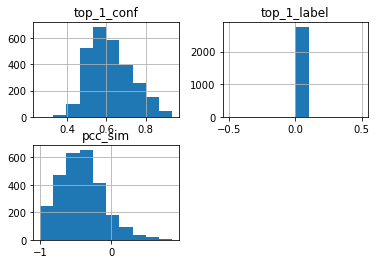

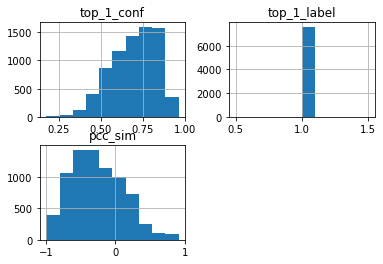

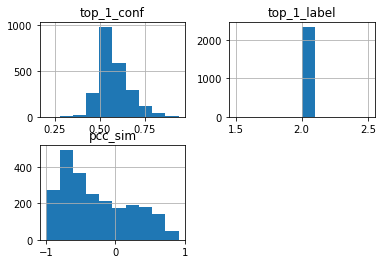

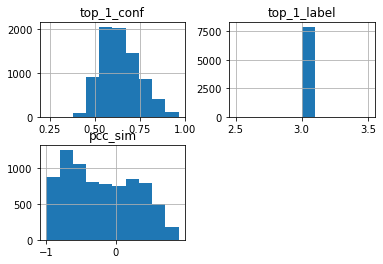

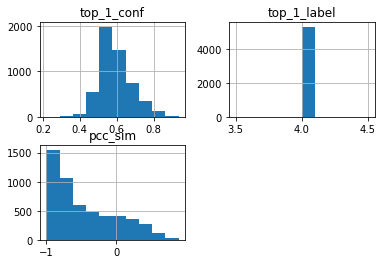

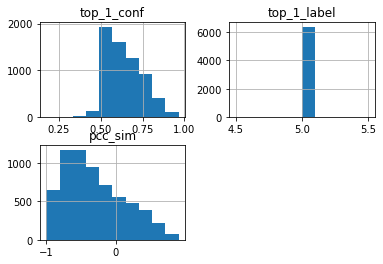

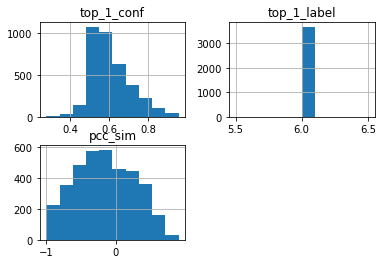

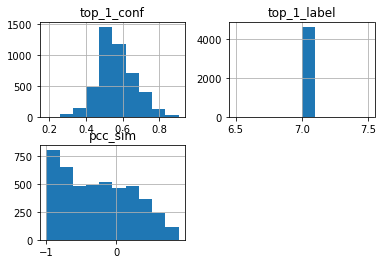

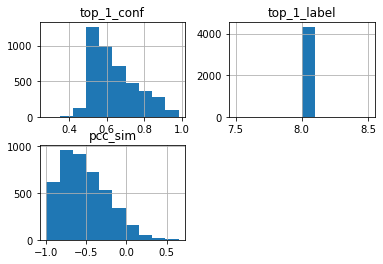

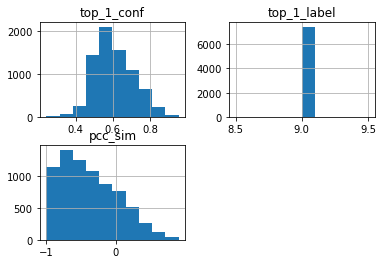

In [36]:
mnist_adv[["top_1_conf", "top_1_label", "pcc_sim"]].groupby(["top_1_label"]).hist()

top_1_label
0.0    [[AxesSubplot(0.125,0.551739;0.336957x0.328261...
1.0    [[AxesSubplot(0.125,0.551739;0.336957x0.328261...
2.0    [[AxesSubplot(0.125,0.551739;0.336957x0.328261...
3.0    [[AxesSubplot(0.125,0.551739;0.336957x0.328261...
4.0    [[AxesSubplot(0.125,0.551739;0.336957x0.328261...
5.0    [[AxesSubplot(0.125,0.551739;0.336957x0.328261...
6.0    [[AxesSubplot(0.125,0.551739;0.336957x0.328261...
7.0    [[AxesSubplot(0.125,0.551739;0.336957x0.328261...
8.0    [[AxesSubplot(0.125,0.551739;0.336957x0.328261...
9.0    [[AxesSubplot(0.125,0.551739;0.336957x0.328261...
dtype: object

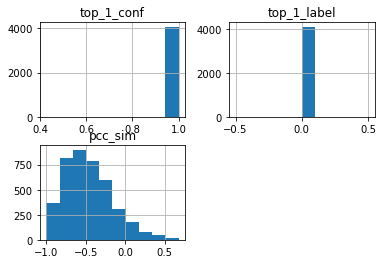

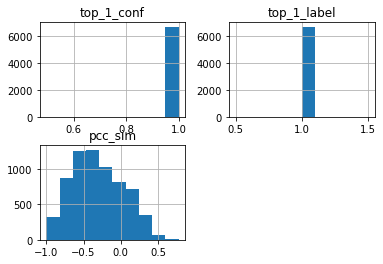

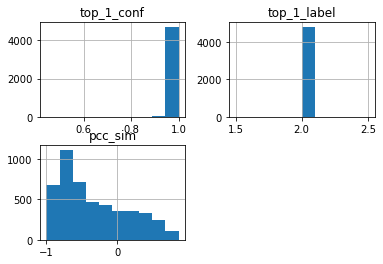

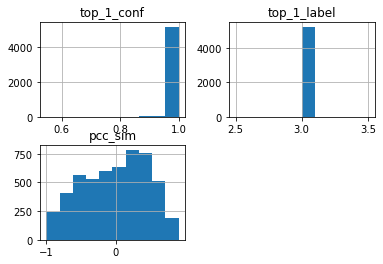

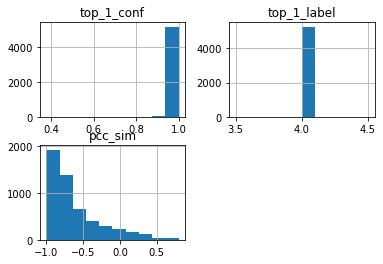

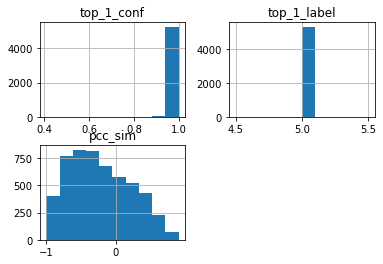

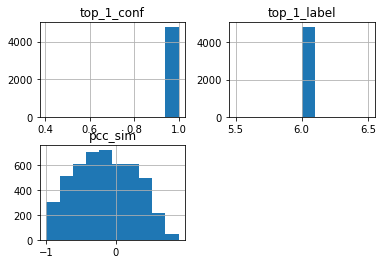

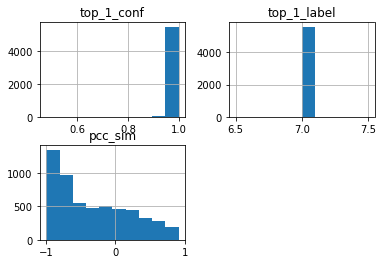

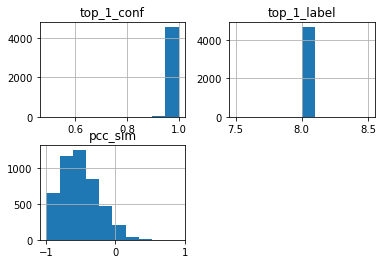

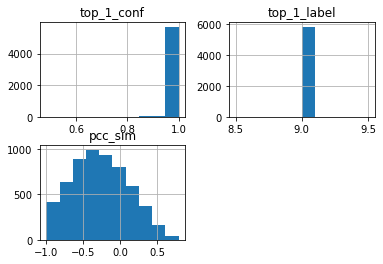

In [37]:
mnist_orig[["top_1_conf", "top_1_label", "pcc_sim"]].groupby(["top_1_label"]).hist()

In [38]:
mnist_adv[["top_1_conf", "top_1_label", "pcc_sim"]].groupby(["top_1_label"]).corr()

top_1_conf   pcc_sim
top_1_label                                 
0.0         top_1_conf    1.000000 -0.051168
            pcc_sim      -0.051168  1.000000
1.0         top_1_conf    1.000000 -0.451068
            pcc_sim      -0.451068  1.000000
2.0         top_1_conf    1.000000  0.002571
            pcc_sim       0.002571  1.000000
3.0         top_1_conf    1.000000  0.234420
            pcc_sim       0.234420  1.000000
4.0         top_1_conf    1.000000 -0.238794
            pcc_sim      -0.238794  1.000000
5.0         top_1_conf    1.000000  0.039357
            pcc_sim       0.039357  1.000000
6.0         top_1_conf    1.000000 -0.145095
            pcc_sim      -0.145095  1.000000
7.0         top_1_conf    1.000000 -0.332511
            pcc_sim      -0.332511  1.000000
8.0         top_1_conf    1.000000  0.165297
            pcc_sim       0.165297  1.000000
9.0         top_1_conf    1.000000  0.036321
            pcc_sim       0.036321  1.000000

In [39]:
cifar10_adv[["top_1_conf", "top_1_label", "pcc_sim"]].groupby(["top_1_label"]).corr()

top_1_conf   pcc_sim
top_1_label                                 
0.0         top_1_conf    1.000000 -0.199558
            pcc_sim      -0.199558  1.000000
1.0         top_1_conf    1.000000 -0.339917
            pcc_sim      -0.339917  1.000000
2.0         top_1_conf    1.000000 -0.018678
            pcc_sim      -0.018678  1.000000
3.0         top_1_conf    1.000000 -0.145831
            pcc_sim      -0.145831  1.000000
4.0         top_1_conf    1.000000 -0.282708
            pcc_sim      -0.282708  1.000000
5.0         top_1_conf    1.000000 -0.337387
            pcc_sim      -0.337387  1.000000
6.0         top_1_conf    1.000000  0.036427
            pcc_sim       0.036427  1.000000
7.0         top_1_conf    1.000000 -0.232959
            pcc_sim      -0.232959  1.000000
8.0         top_1_conf    1.000000 -0.192094
            pcc_sim      -0.192094  1.000000
9.0         top_1_conf    1.000000 -0.401897
            pcc_sim      -0.401897  1.000000

In [40]:
cifar10_adv["top_diff"] = cifar10_adv["top_1_conf"] - cifar10_adv["top_2_conf"]

In [41]:
cifar10_adv[["top_diff", "top_1_label", "pcc_sim"]].groupby(["top_1_label"]).corr()

top_diff   pcc_sim
top_1_label                             
0.0         top_diff  1.000000 -0.223772
            pcc_sim  -0.223772  1.000000
1.0         top_diff  1.000000 -0.284588
            pcc_sim  -0.284588  1.000000
2.0         top_diff  1.000000 -0.022319
            pcc_sim  -0.022319  1.000000
3.0         top_diff  1.000000 -0.129757
            pcc_sim  -0.129757  1.000000
4.0         top_diff  1.000000 -0.273990
            pcc_sim  -0.273990  1.000000
5.0         top_diff  1.000000 -0.279884
            pcc_sim  -0.279884  1.000000
6.0         top_diff  1.000000  0.029320
            pcc_sim   0.029320  1.000000
7.0         top_diff  1.000000 -0.268951
            pcc_sim  -0.268951  1.000000
8.0         top_diff  1.000000 -0.201360
            pcc_sim  -0.201360  1.000000
9.0         top_diff  1.000000 -0.371642
            pcc_sim  -0.371642  1.000000

<AxesSubplot:>

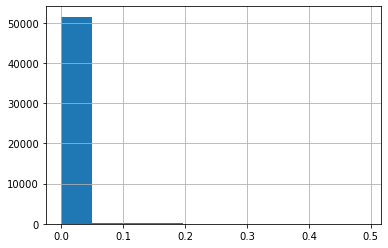

In [42]:
top_k_mnist_train_orig.sort_values(by="top_2_conf", ascending=True)["top_2_conf"].hist()

In [43]:
top_k_mnist_train_adv.sort_values(by="top_1_conf", ascending=True)

,top_1_label,top_1_conf,top_2_label,top_2_conf
35052,5.0,0.173837,7.0,0.152706
23234,1.0,0.176650,7.0,0.132356
6715,7.0,0.184242,3.0,0.165901
1667,1.0,0.198748,6.0,0.182419
37128,5.0,0.203248,7.0,0.197079
...,...,...,...,...
38532,5.0,0.965993,8.0,0.033805
39861,8.0,0.966964,2.0,0.032308
24179,8.0,0.975055,2.0,0.024874
37623,8.0,0.976496,2.0,0.022422


In [44]:
top_k_cifar10_train_orig.head()

,top_1_label,top_1_conf,top_2_label,top_2_conf
0,3.0,0.884584,5.0,0.038046
1,3.0,0.763706,0.0,0.065399
2,0.0,0.630749,3.0,0.204524
3,3.0,0.781105,5.0,0.133733
4,3.0,0.599040,0.0,0.090341


In [45]:
top_k_cifar10_train_orig.head()

,top_1_label,top_1_conf,top_2_label,top_2_conf
0,3.0,0.884584,5.0,0.038046
1,3.0,0.763706,0.0,0.065399
2,0.0,0.630749,3.0,0.204524
3,3.0,0.781105,5.0,0.133733
4,3.0,0.599040,0.0,0.090341


In [46]:
top_k_cifar10_train_adv.head()

,top_1_label,top_1_conf,top_2_label,top_2_conf
0,3.0,0.809320,4.0,0.068449
1,3.0,0.873839,6.0,0.034610
2,0.0,0.568806,3.0,0.252050
3,3.0,0.743912,5.0,0.161988
4,3.0,0.598399,5.0,0.090844


In [47]:
d = pd.DataFrame(mnist_train_confidences_orig.numpy())

In [48]:
val, idcs = torch.topk(mnist_train_confidences_orig, k=2, dim=1)

In [49]:
idcs

tensor([[7, 9],
        [5, 3],
        [9, 8],
        ...,
        [4, 9],
        [9, 4],
        [9, 4]])

In [50]:
idcs[:,0]

tensor([7, 5, 9,  ..., 4, 9, 9])

In [51]:
df = pd.DataFrame([idcs[:,0].numpy(), val[:,0].numpy(),idcs[:,1].numpy(), val[:,1].numpy()], index=["top_1_idx", "top_1_conf", "top_2_idx", "top_2_conf"]).T

In [52]:
df.head()

,top_1_idx,top_1_conf,top_2_idx,top_2_conf
0,7.0,1.000000,9.0,7.216924e-08
1,5.0,0.984226,3.0,1.147289e-02
2,9.0,0.999952,8.0,4.078618e-05
3,7.0,0.999750,2.0,1.813207e-04
4,4.0,1.000000,9.0,4.286920e-07


In [53]:
largest_indcs = d.T.nlargest(n=2, columns=range(0, d.shape[0])).index

In [54]:
largest_indcs

Int64Index([7, 9], dtype='int64')

In [55]:
d.T.loc[largest_indcs]

,0,1,2,3,4,5,6,7,8,9,...,52285,52286,52287,52288,52289,52290,52291,52292,52293,52294
7,9.999999e-01,0.000002,0.000001,0.999750,6.488721e-08,1.000000e+00,8.847245e-17,2.825724e-12,6.712441e-12,2.200307e-15,...,7.581013e-10,1.465759e-08,1.893714e-08,1.018177e-09,3.269034e-14,0.000036,1.460610e-12,0.000003,1.647018e-07,5.196413e-07
9,7.216924e-08,0.000157,0.999952,0.000011,4.286920e-07,1.866005e-08,3.856242e-08,7.875891e-08,1.239593e-10,1.182660e-09,...,1.000000e+00,1.000000e+00,1.000000e+00,9.999998e-01,3.464417e-11,0.997996,1.519156e-07,0.000020,9.999893e-01,9.999928e-01


In [56]:
d.idxmax(axis=1)

0        7
1        5
2        9
3        7
4        4
        ..
52290    9
52291    5
52292    4
52293    9
52294    9
Length: 52295, dtype: int64

In [57]:
mnist_train_label_orig.numpy()

array([7., 5., 9., ..., 4., 9., 9.], dtype=float32)

In [58]:
np.sum(mnist_train_label_orig.numpy() == mnist_train_confidences_orig.numpy().argmax(axis=1))

52282

In [59]:
df_mnist_train = pd.DataFrame(mnist_train_confidences_orig.numpy())

In [60]:
df_mnist_train.idxmax(axis=1)

0        7
1        5
2        9
3        7
4        4
        ..
52290    9
52291    5
52292    4
52293    9
52294    9
Length: 52295, dtype: int64

## Why are the correctly classified counts so low??

In [ ]:
np.sum(mnist_train_confidences_orig.numpy().argmax(axis=1) == mnist_train_labels_orig.numpy())

In [ ]:
np.sum(fashion_mnist_train_confidences_orig.numpy().argmax(axis=1) == fashion_mnist_train_labels_orig.numpy())

In [ ]:
np.sum(cifar10_train_confidences_orig.numpy().argmax(axis=1) == cifar10_train_labels_orig.numpy())

In [ ]:
df_mnist_train_conf = pd.DataFrame(mnist_train_confidences_orig.numpy())

In [ ]:
df_mnist_train_conf.head()

In [ ]:
pred_labels = df_mnist_train_conf.idxmax(axis=1).to_numpy()

In [ ]:
df_mnist_train_labels

In [ ]:
pred_labels

# Q1: How is the distribution of classes in the data sets?

## MNIST

### Original

## FashionMNIST

## Labels mappings:
* 0	T-shirt/top
* 1	Trouser
* 2	Pullover
* 3	Dress
* 4	Coat
* 5	Sandal
* 6	Shirt
* 7	Sneaker
* 8	Bag
* 9	Ankle boot

### Original

### Adversarial

## CIFAR10

Label mappings:
* 0	Airplane
* 1	Car
* 2	Bird
* 3	Cat
* 4	Deer
* 5	Dog
* 6	Frog
* 7	Horse
* 8	Ship
* 9	Truck

### Original

### Adversarial